In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [17]:
df= pd.read_csv("../dataset/loan_data.csv")
print(df.columns)

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'previous_loan_defaults_on_file', 'loan_status'],
      dtype='object')


In [18]:
null_percentage = df.isnull().mean() * 100
null_percentage

person_age                        0.0
person_gender                     0.0
person_education                  0.0
person_income                     0.0
person_emp_exp                    0.0
person_home_ownership             0.0
loan_amnt                         0.0
loan_intent                       0.0
loan_int_rate                     0.0
loan_percent_income               0.0
cb_person_cred_hist_length        0.0
credit_score                      0.0
previous_loan_defaults_on_file    0.0
loan_status                       0.0
dtype: float64

<Figure size 600x600 with 0 Axes>

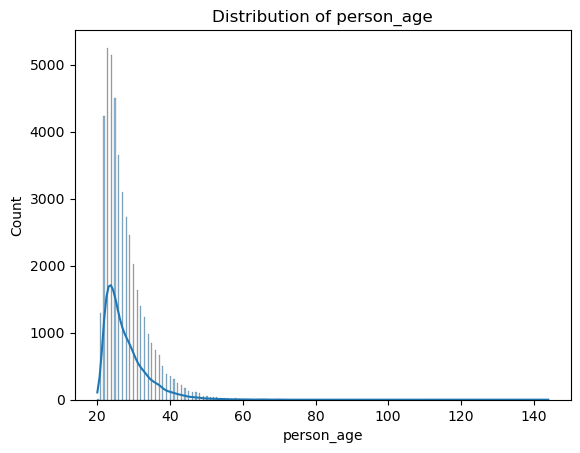

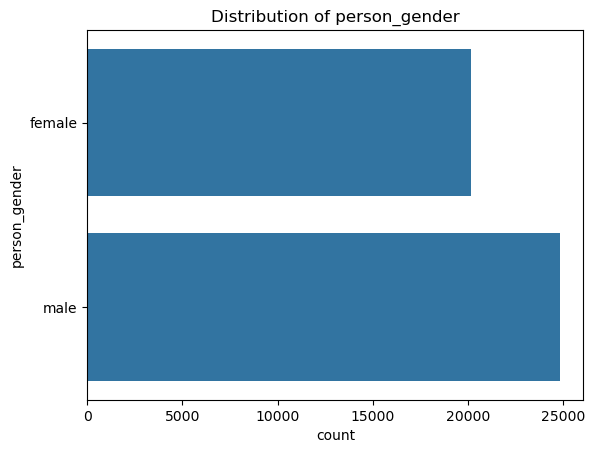

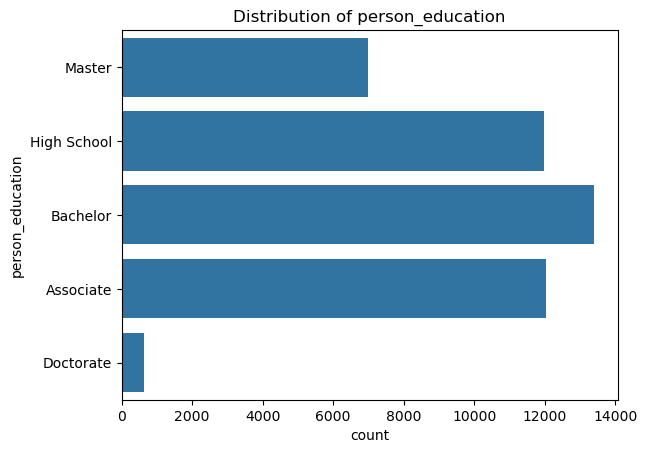

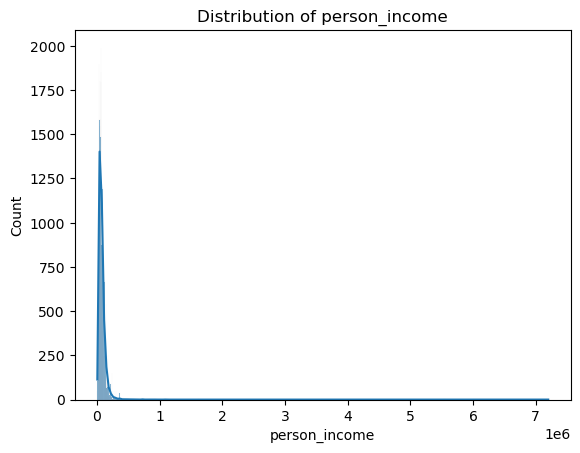

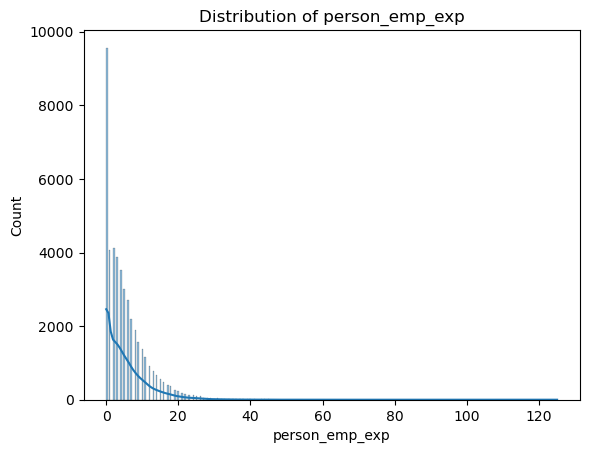

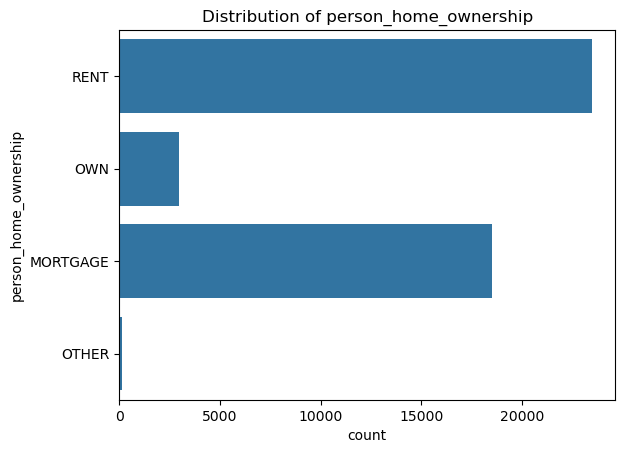

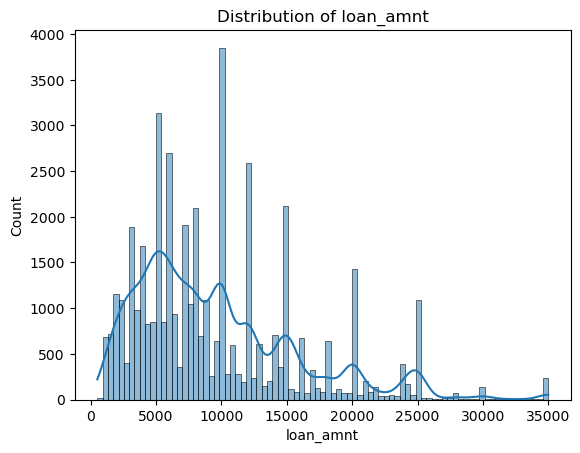

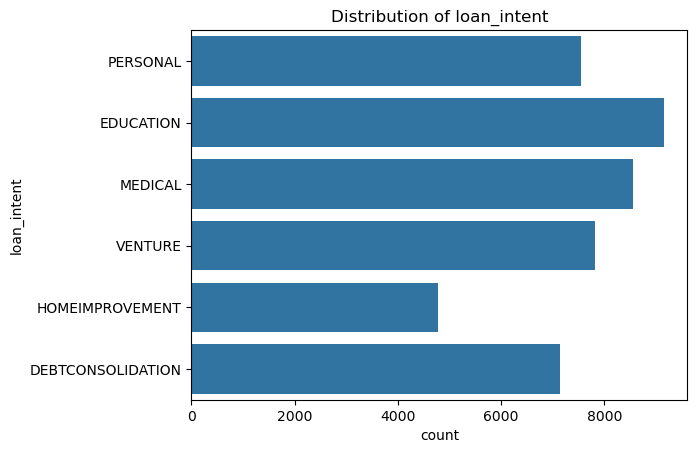

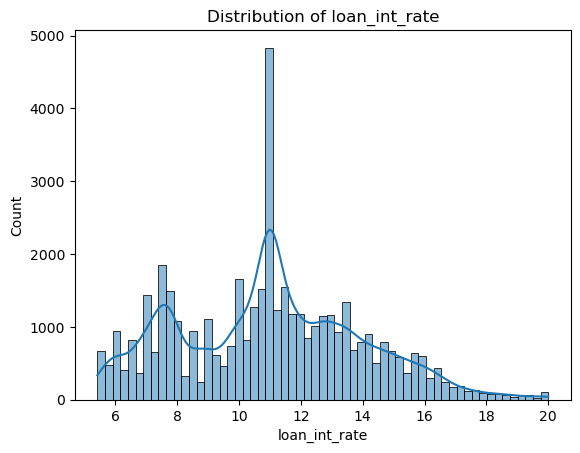

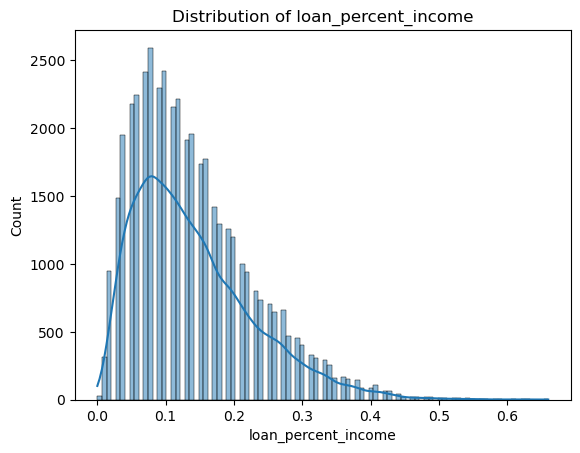

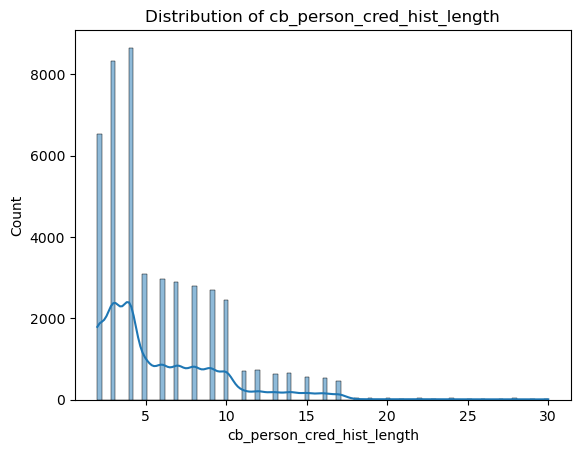

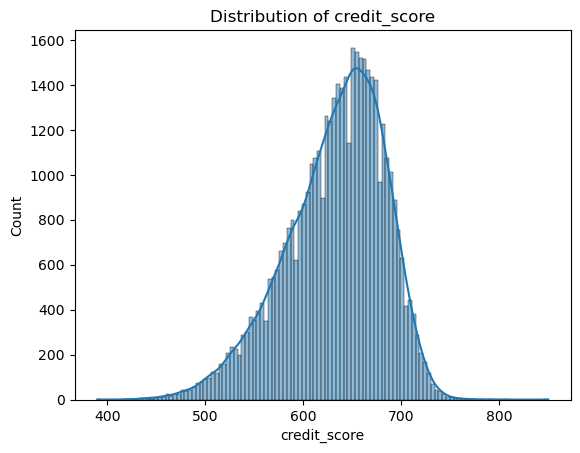

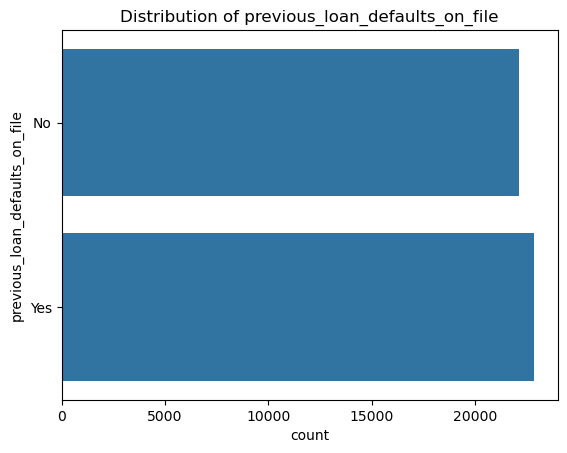

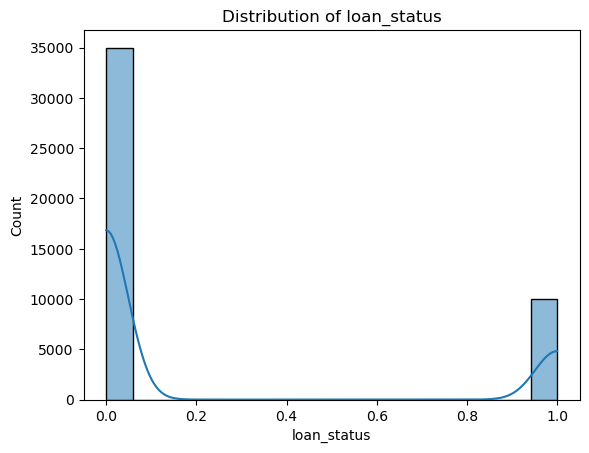

In [19]:
plt.figure(figsize=(6, 6))
for column in df.columns:
    plt.figure()
    if pd.api.types.is_numeric_dtype(df[column]):
        # Plot distribution for numerical features
        sns.histplot(df[column].dropna(), kde=True)
        plt.title(f'Distribution of {column}')
    else:
        # Plot count plot for categorical features
        sns.countplot(y=df[column].dropna())
        plt.title(f'Distribution of {column}')
    plt.show()

In [22]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply the function to each numerical column
for column in ['person_age','person_income','person_emp_exp']:
    df = remove_outliers(df, column)

# Display the DataFrame after removing outliers
print(df)

       person_age person_gender person_education  person_income  \
0            22.0        female           Master        71948.0   
1            21.0        female      High School        12282.0   
2            25.0        female      High School        12438.0   
3            23.0        female         Bachelor        79753.0   
4            24.0          male           Master        66135.0   
...           ...           ...              ...            ...   
44994        24.0        female        Associate        31924.0   
44995        27.0          male        Associate        47971.0   
44997        33.0          male        Associate        56942.0   
44998        29.0          male         Bachelor        33164.0   
44999        24.0          male      High School        51609.0   

       person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
0                   0                  RENT    35000.0           PERSONAL   
1                   0                   O

In [23]:
df.loan_status.value_counts()

loan_status
0    31051
1     9250
Name: count, dtype: int64

In [31]:
df.dtypes


person_age                        float64
person_gender                      object
person_education                   object
person_income                     float64
person_emp_exp                      int64
person_home_ownership              object
loan_amnt                         float64
loan_intent                        object
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length        float64
credit_score                        int64
previous_loan_defaults_on_file     object
loan_status                         int64
dtype: object

In [33]:
for column in df.select_dtypes(include=['object']).columns:
    print(df[column].value_counts())
    print("__________________________")

person_gender
male      22121
female    18180
Name: count, dtype: int64
__________________________
person_education
Bachelor       12365
Associate      10584
High School    10534
Master          6373
Doctorate        445
Name: count, dtype: int64
__________________________
person_home_ownership
RENT        21715
MORTGAGE    15854
OWN          2631
OTHER         101
Name: count, dtype: int64
__________________________
loan_intent
EDUCATION            8371
MEDICAL              7739
VENTURE              7009
PERSONAL             6663
DEBTCONSOLIDATION    6382
HOMEIMPROVEMENT      4137
Name: count, dtype: int64
__________________________
previous_loan_defaults_on_file
Yes    20456
No     19845
Name: count, dtype: int64
__________________________


In [37]:
categorical_columns = df.select_dtypes(include=['object']).columns
p_values = pd.DataFrame(index=categorical_columns, columns=categorical_columns)
for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 != col2:
            contingency_table = pd.crosstab(df[col1], df[col2])
            #print(contingency_table)
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            print(col1,col2)
            print(chi2, p, dof, expected)
            p_values.loc[col1, col2] = p
        else:
            p_values.loc[col1, col2] = 1  
p_values = p_values.apply(pd.to_numeric)
p_values.fillna(1, inplace=True)


person_gender person_education
0.9828130901548543 0.9123907922501429 4 [[4774.49988834 5577.91866207  200.74191707 4751.94461676 2874.89491576]
 [5809.50011166 6787.08133793  244.25808293 5782.05538324 3498.10508424]]
person_gender person_home_ownership
0.10183020856837538 0.9916168907614987 3 [[ 7151.82551301    45.56164859  1186.85839061  9795.75444778]
 [ 8702.17448699    55.43835141  1444.14160939 11919.24555222]]
person_gender loan_intent
2.0651005250914616 0.840065805203454 5 [[2878.95486464 3776.20356815 1866.22317064 3491.10493536 3005.71549093
  3161.79797027]
 [3503.04513536 4594.79643185 2270.77682936 4247.89506464 3657.28450907
  3847.20202973]]
person_gender previous_loan_defaults_on_file
0.8232222041074937 0.36423975039539136 1 [[ 8952.18729064  9227.81270936]
 [10892.81270936 11228.18729064]]
person_education person_gender
0.9828130901548542 0.9123907922501429 4 [[4774.49988834 5809.50011166]
 [5577.91866207 6787.08133793]
 [ 200.74191707  244.25808293]
 [4751.94461676 5

In [40]:
significance_threshold = 0.05
features_to_remove = []
print(p_values)
for col in p_values.columns:
    if (p_values[col] > significance_threshold).all():
    
        features_to_remove.append(col)

df=df.drop(columns="person_gender")

                                person_gender  person_education  \
person_gender                        1.000000      9.123908e-01   
person_education                     0.912391      1.000000e+00   
person_home_ownership                0.991617      4.820260e-01   
loan_intent                          0.840066      2.798274e-03   
previous_loan_defaults_on_file       0.364240      2.252203e-13   

                                person_home_ownership    loan_intent  \
person_gender                            9.916169e-01   8.400658e-01   
person_education                         4.820260e-01   2.798274e-03   
person_home_ownership                    1.000000e+00  1.195458e-160   
loan_intent                             1.195458e-160   1.000000e+00   
previous_loan_defaults_on_file          1.264040e-172   7.645851e-57   

                                previous_loan_defaults_on_file  
person_gender                                     3.642398e-01  
person_education                  

In [44]:
df=pd.get_dummies(df,columns=["loan_intent"])
categories = [
    ['High School','Bachelor', 'Associate', 'Master','Doctorate'],  # Categories for 'size'
    ['OTHER', 'RENT', 'MORTGAGE','OWN'],     # Categories for 'quality'
    ['Yes','No']
]
encoder = OrdinalEncoder(categories=categories)
df[['person_education','person_home_ownership','previous_loan_defaults_on_file']] = encoder.fit_transform(df[['person_education','person_home_ownership','previous_loan_defaults_on_file']])




In [45]:
print(df.columns)

Index(['person_age', 'person_education', 'person_income', 'person_emp_exp',
       'person_home_ownership', 'loan_amnt', 'loan_int_rate',
       'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score',
       'previous_loan_defaults_on_file', 'loan_status',
       'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE'],
      dtype='object')


In [48]:
df.head()

,person_age,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,22.0,3.0,71948.0,0,1.0,35000.0,16.02,0.49,3.0,561,1.0,1,False,False,False,False,True,False
1,21.0,0.0,12282.0,0,3.0,1000.0,11.14,0.08,2.0,504,0.0,0,False,True,False,False,False,False
2,25.0,0.0,12438.0,3,2.0,5500.0,12.87,0.44,3.0,635,1.0,1,False,False,False,True,False,False
3,23.0,1.0,79753.0,0,1.0,35000.0,15.23,0.44,2.0,675,1.0,1,False,False,False,True,False,False
4,24.0,3.0,66135.0,1,1.0,35000.0,14.27,0.53,4.0,586,1.0,1,False,False,False,True,False,False


In [59]:
features_to_standardize = ['person_age',  'person_income', 'loan_amnt',  'loan_percent_income', 'cb_person_cred_hist_length','credit_score']  # Replace with your feature names
df1=df.copy()
scaler = StandardScaler()
df[features_to_standardize] = scaler.fit_transform(df[features_to_standardize])

# Display the standardized DataFrame
print(df)

       person_age  person_education  person_income  person_emp_exp  \
0            22.0               3.0        71948.0               0   
1            21.0               0.0        12282.0               0   
2            25.0               0.0        12438.0               3   
3            23.0               1.0        79753.0               0   
4            24.0               3.0        66135.0               1   
...           ...               ...            ...             ...   
44994        24.0               2.0        31924.0               2   
44995        27.0               2.0        47971.0               6   
44997        33.0               2.0        56942.0               7   
44998        29.0               1.0        33164.0               4   
44999        24.0               0.0        51609.0               1   

       person_home_ownership  loan_amnt  loan_int_rate  loan_percent_income  \
0                        1.0    35000.0          16.02                 0.49   
1

In [60]:
df.dtypes

person_age                        float64
person_education                  float64
person_income                     float64
person_emp_exp                      int64
person_home_ownership             float64
loan_amnt                         float64
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length        float64
credit_score                      float64
previous_loan_defaults_on_file    float64
loan_status                         int64
loan_intent_DEBTCONSOLIDATION        bool
loan_intent_EDUCATION                bool
loan_intent_HOMEIMPROVEMENT          bool
loan_intent_MEDICAL                  bool
loan_intent_PERSONAL                 bool
loan_intent_VENTURE                  bool
dtype: object

In [64]:
X,y=df.drop(columns=["loan_status"]),df["loan_status"]
print(X,y)


       person_age  person_education  person_income  person_emp_exp  \
0       -1.124711               3.0       0.041830               0   
1       -1.368112               0.0      -1.804108               0   
2       -0.394506               0.0      -1.799282               3   
3       -0.881309               1.0       0.283300               0   
4       -0.637908               3.0      -0.138011               1   
...           ...               ...            ...             ...   
44994   -0.637908               2.0      -1.196427               2   
44995    0.092297               2.0      -0.699967               6   
44997    1.552706               2.0      -0.422423               7   
44998    0.579100               1.0      -1.158064               4   
44999   -0.637908               0.0      -0.587415               1   

       person_home_ownership  loan_amnt  loan_int_rate  loan_percent_income  \
0                        1.0   4.274302          16.02             3.952066   
1

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [70]:
y_pred = model.predict(X_test)

In [71]:
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(class_report)
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.9306537650415582
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      6192
           1       0.92      0.77      0.84      1869

    accuracy                           0.93      8061
   macro avg       0.93      0.87      0.90      8061
weighted avg       0.93      0.93      0.93      8061

Confusion Matrix:
[[6062  130]
 [ 429 1440]]
